# Enhancing Single-Image Super-Resolution

Muneerah AlDhafian (446200418),
Maha AlHazzani (446201187),
and Reem AlShehri (446200905)

CSC 564: ML

Department of computer science

King Saud University


### Project Roadmap
- Import Libraries
- Dataset
- CNN

### 1. Import Libraries

In [1]:
# Import necessary libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import vgg19
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim # For SSIM Loss if needed later

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1.1 Download and Extract DIV2K Dataset

The following cells download the necessary DIV2K dataset components (Train HR/LR, Valid HR/LR) and extract them into the `/content/data` directory.

In [3]:
# Create data directory
!mkdir -p /content/data
%cd /content/data

# Download Train Set (HR and LR)
print("Downloading DIV2K Training Set...")
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip

# Download Validation Set (HR and LR)  - This will be our Test Set
print("Downloading DIV2K Validation Set (used as Test Set)...")
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip

# Extract downloaded files
print("Extracting files...")
!unzip -o -q DIV2K_train_HR.zip
!unzip -o -q DIV2K_train_LR_bicubic_X4.zip -d DIV2K_train_LR_bicubic # Extract LR into its own subdir
!unzip -o -q DIV2K_valid_HR.zip
!unzip -o -q DIV2K_valid_LR_bicubic_X4.zip -d DIV2K_valid_LR_bicubic # Extract LR into its own subdir

print("Dataset download and extraction complete.")
%cd /content # Corrected: Change back to root directory (comment removed)

/content/data
--2025-05-04 22:19:32--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-05-04 22:19:32--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  21.5MB/s    in 2m 38s  

2025-05-04 22:22:11 (21.3 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

--2025-05-04 22:22:11--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
Resolvi

### 1.2 Dataset Paths and Parameters

Define paths to the downloaded DIV2K dataset components. We will use the DIV2K *training* set for training and validation, and the DIV2K *validation* set as our final test set.

In [15]:
# Define paths (assuming data is downloaded in /content/data)
base_data_path = "/content/data"

# Check if the base path exists after download/extraction
if not os.path.exists(base_data_path) or not os.path.exists(os.path.join(base_data_path, "DIV2K_train_HR")):
    print(f"Warning: Dataset path {base_data_path} or its contents not found. Please ensure the download/extraction cell ran successfully.")
else:
    print(f"Dataset base path found: {base_data_path}")

train_hr_dir = os.path.join(base_data_path, "DIV2K_train_HR")
# Corrected path for LR train images based on unzip structure
train_lr_dir = os.path.join(base_data_path, "DIV2K_train_LR_bicubic", "DIV2K_train_LR_bicubic", "X4")

# Use the original DIV2K validation set as our test set
test_hr_dir = os.path.join(base_data_path, "DIV2K_valid_HR")
# Corrected path for LR test images based on unzip structure
test_lr_dir = os.path.join(base_data_path, "DIV2K_valid_LR_bicubic", "DIV2K_valid_LR_bicubic", "X4")

# Parameters
scale_factor = 4
hr_patch_size = 96 # Size of HR patches to crop for training
lr_patch_size = hr_patch_size // scale_factor # Corresponding LR patch size
batch_size = 8 # Adjust based on GPU memory
validation_split = 0.1 # Use 10% of training data for validation

Dataset base path found: /content/data


### 1.3 Dataset Class with Random Cropping

This dataset class loads HR/LR pairs and applies random cropping and augmentations during training.

In [14]:
from PIL import Image, ImageFilter


class DIV2KCroppedDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, hr_patch_size, scale_factor, split="train", transform=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_patch_size = hr_patch_size
        self.lr_patch_size = hr_patch_size // scale_factor
        self.scale_factor = scale_factor
        self.split = split
        self.transform = transform

        self.hr_image_files = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        # LR files are expected inside the X4 subdirectory
        self.lr_image_files = sorted(glob.glob(os.path.join(lr_dir, "*.png")))

        if not self.hr_image_files:
            raise FileNotFoundError(f"No HR images found in {hr_dir}")
        if not self.lr_image_files:
             raise FileNotFoundError(f"No LR images found in {lr_dir}")

        # Verify counts (optional but good practice)
        print(f"Found {len(self.hr_image_files)} HR images in {hr_dir}")
        print(f"Found {len(self.lr_image_files)} LR images in {lr_dir}")

    def __len__(self):
        return len(self.hr_image_files)

    def __getitem__(self, idx):
        hr_img_path = self.hr_image_files[idx]
        # Construct LR path based on HR filename (e.g., 0001.png -> 0001x4.png)
        hr_basename = os.path.basename(hr_img_path)
        lr_basename = hr_basename.replace(".png", f"x{self.scale_factor}.png")
        lr_img_path = os.path.join(self.lr_dir, lr_basename)

        try:
            hr_image = Image.open(hr_img_path).convert("RGB")
            lr_image = Image.open(lr_img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error loading image pair: HR={hr_img_path}, Expected LR={lr_img_path}")
            # Handle error, e.g., skip this sample or return dummy data
            # For simplicity, let's try loading the next image
            return self.__getitem__((idx + 1) % len(self))

        if self.split == "train":
            # Get random crop parameters based on LR image size
            lr_w, lr_h = lr_image.size
            if lr_w < self.lr_patch_size or lr_h < self.lr_patch_size:
                # If LR image is too small, resize it up slightly bigger than patch size
                target_size = max(self.lr_patch_size, lr_w, lr_h)
                lr_image = TF.resize(lr_image, target_size, interpolation=Image.BICUBIC)
                hr_image = TF.resize(hr_image, target_size * self.scale_factor, interpolation=Image.BICUBIC)

            i, j, h, w = transforms.RandomCrop.get_params(
                lr_image, output_size=(self.lr_patch_size, self.lr_patch_size)
            )
            lr_patch = TF.crop(lr_image, i, j, h, w)
            hr_patch = TF.crop(hr_image, i * self.scale_factor, j * self.scale_factor, h * self.scale_factor, w * self.scale_factor)

            # Apply random horizontal flip
            if random.random() > 0.5:
                lr_patch = TF.hflip(lr_patch)
                hr_patch = TF.hflip(hr_patch)

            # Apply random vertical flip
            if random.random() > 0.5:
                lr_patch = TF.vflip(lr_patch)
                hr_patch = TF.vflip(hr_patch)

        else: # For validation/test, use full image
            lr_patch = lr_image
            hr_patch = hr_image

        # Apply transforms (ToTensor, normalization etc.)
        if self.transform:
            lr_patch = self.transform(lr_patch)
            hr_patch = self.transform(hr_patch)

        return lr_patch, hr_patch

    # def __getitem__(self, idx):
    #   hr_img_path = self.hr_image_files[idx]

    #   try:
    #       hr_image = Image.open(hr_img_path).convert("RGB")
    #   except FileNotFoundError:
    #       print(f"Error loading HR image: {hr_img_path}")
    #       return self.__getitem__((idx + 1) % len(self))

    #   if self.split == "train":
    #       # Ensure image is large enough to crop
    #       w, h = hr_image.size
    #       patch_size = self.lr_patch_size * self.scale_factor
    #       if w < patch_size or h < patch_size:
    #           hr_image = TF.resize(hr_image, size=(patch_size, patch_size), interpolation=Image.BICUBIC)

    #       # Random crop from HR
    #       i, j, h, w = transforms.RandomCrop.get_params(hr_image, output_size=(patch_size, patch_size))
    #       hr_patch = TF.crop(hr_image, i, j, h, w)

    #       # Generate blurry LR from HR patch
    #       lr_patch = simulate_blurry_lr(hr_patch, scale=self.scale_factor)

    #       # Data augmentation: horizontal & vertical flips
    #       if random.random() > 0.5:
    #           lr_patch = TF.hflip(lr_patch)
    #           hr_patch = TF.hflip(hr_patch)
    #       if random.random() > 0.5:
    #           lr_patch = TF.vflip(lr_patch)
    #           hr_patch = TF.vflip(hr_patch)
    #   else:
    #       # Validation/test: use full HR image and generate LR from it
    #       hr_patch = hr_image
    #       lr_patch = simulate_blurry_lr(hr_image, scale=self.scale_factor)

    #   # Apply any transforms (e.g., ToTensor)
    #   if self.transform:
    #       lr_patch = self.transform(lr_patch)
    #       hr_patch = self.transform(hr_patch)

    #   return lr_patch, hr_patch

### 1.4 Data Loaders Setup (Train/Validation/Test Split)

In [16]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor() # Converts PIL image [0, 255] to tensor [0, 1]
])

# Load the full training dataset
try:
    full_train_dataset = DIV2KCroppedDataset(
        hr_dir=train_hr_dir,
        lr_dir=train_lr_dir,
        hr_patch_size=hr_patch_size,
        scale_factor=scale_factor,
        split="train",
        transform=transform
    )
    num_train = len(full_train_dataset)
except FileNotFoundError as e:
    print(f"Error initializing training dataset: {e}. Please check paths and ensure data is extracted.")
    num_train = 0 # Set to 0 to prevent further errors

if num_train > 0:
    # Split training data into training and validation sets
    indices = list(range(num_train))
    split_idx = int(np.floor(validation_split * num_train))

    # Shuffle indices before splitting
    np.random.seed(42) # for reproducibility
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split_idx:], indices[:split_idx]

    # Create subset datasets
    train_subset = Subset(full_train_dataset, train_indices)

    # Create a separate dataset instance for validation to avoid random cropping
    val_dataset_config = {
        "hr_dir": train_hr_dir,
        "lr_dir": train_lr_dir,
        "hr_patch_size": hr_patch_size, # Not used if split != train
        "scale_factor": scale_factor,
        "split": "validation", # Use full images for validation
        "transform": transform
    }
    try:
        full_val_dataset = DIV2KCroppedDataset(**val_dataset_config)
        val_subset = Subset(full_val_dataset, val_indices)
    except FileNotFoundError as e:
        print(f"Error initializing validation dataset: {e}.")
        val_subset = None # Mark as None if error

    # Load the test dataset (using DIV2K validation set)
    test_dataset_config = {
        "hr_dir": test_hr_dir,
        "lr_dir": test_lr_dir,
        "hr_patch_size": hr_patch_size, # Not used if split != train
        "scale_factor": scale_factor,
        "split": "test", # Use full images for test
        "transform": transform
    }
    try:
        test_dataset = DIV2KCroppedDataset(**test_dataset_config)
    except FileNotFoundError as e:
        print(f"Error initializing test dataset: {e}.")
        test_dataset = None # Mark as None if error

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True) if val_subset else None
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True) if test_dataset else None

    print(f"Full training dataset size: {num_train}")
    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset) if val_subset else 0}")
    print(f"Test dataset size: {len(test_dataset) if test_dataset else 0}")
else:
    print("Skipping DataLoader creation due to dataset initialization error.")
    train_loader, val_loader, test_loader = None, None, None

Found 800 HR images in /content/data/DIV2K_train_HR
Found 800 LR images in /content/data/DIV2K_train_LR_bicubic/DIV2K_train_LR_bicubic/X4
Found 800 HR images in /content/data/DIV2K_train_HR
Found 800 LR images in /content/data/DIV2K_train_LR_bicubic/DIV2K_train_LR_bicubic/X4
Found 100 HR images in /content/data/DIV2K_valid_HR
Found 100 LR images in /content/data/DIV2K_valid_LR_bicubic/DIV2K_valid_LR_bicubic/X4
Full training dataset size: 800
Training subset size: 720
Validation subset size: 80
Test dataset size: 100


### 1.5 Visualize Data Samples

Sample from Training Loader (Patches):


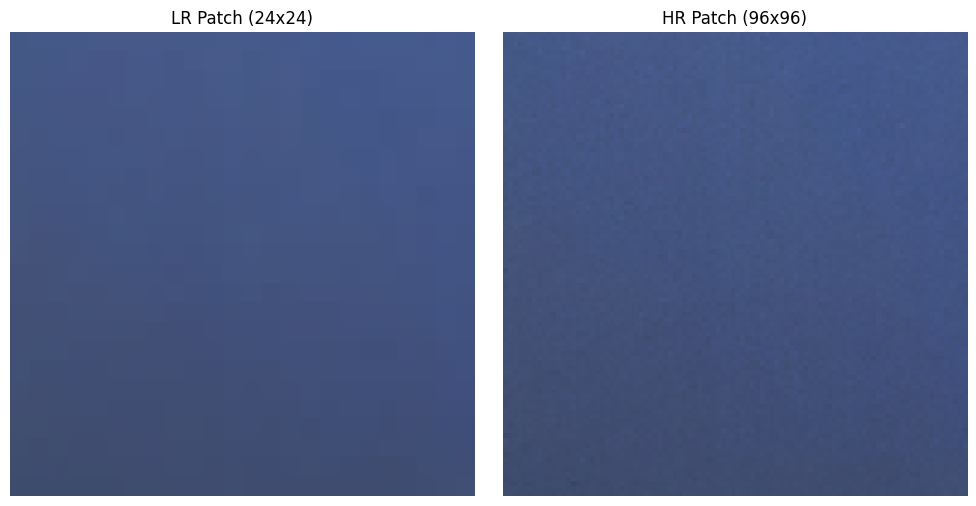


Sample from Validation Loader (Full Images):


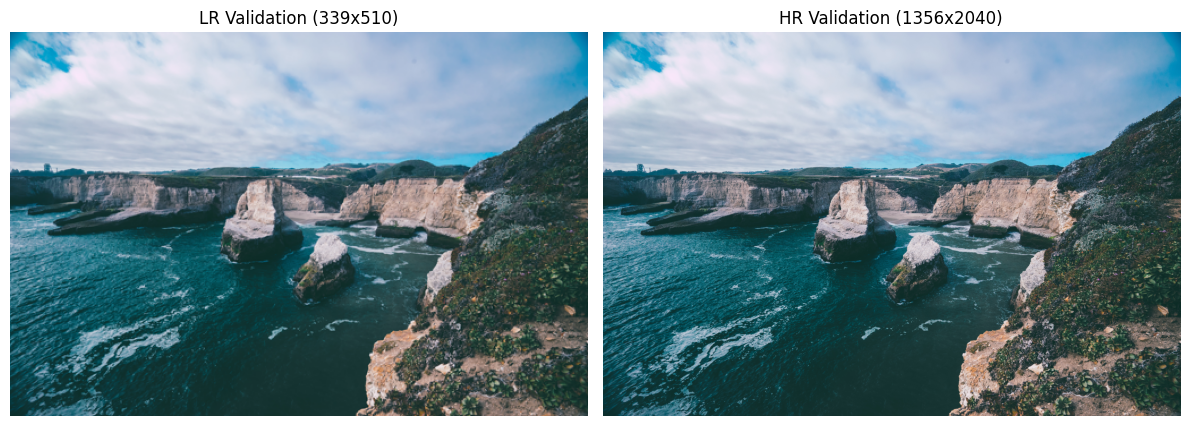

In [17]:
# Function to display images
def show_tensor_image(tensor_img, title=""):
    img = tensor_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1) # Ensure values are in [0, 1]
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Visualize a sample from the train loader (cropped patches)
if train_loader:
    print("Sample from Training Loader (Patches):")
    try:
        lr_patch_sample, hr_patch_sample = next(iter(train_loader))
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        show_tensor_image(lr_patch_sample[0], f"LR Patch ({lr_patch_sample[0].shape[-2]}x{lr_patch_sample[0].shape[-1]})")
        plt.subplot(1, 2, 2)
        show_tensor_image(hr_patch_sample[0], f"HR Patch ({hr_patch_sample[0].shape[-2]}x{hr_patch_sample[0].shape[-1]})")
        plt.tight_layout()
        plt.show()
    except StopIteration:
        print("Could not get sample from train_loader (possibly empty dataset or split issue).")
    except Exception as e:
        print(f"Error visualizing train sample: {e}")
else:
    print("Train loader not available for visualization.")

# Visualize a sample from the validation loader (full images)
if val_loader:
    print("\nSample from Validation Loader (Full Images):")
    try:
        lr_val_sample, hr_val_sample = next(iter(val_loader))
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        show_tensor_image(lr_val_sample[0], f"LR Validation ({lr_val_sample[0].shape[-2]}x{lr_val_sample[0].shape[-1]})")
        plt.subplot(1, 2, 2)
        show_tensor_image(hr_val_sample[0], f"HR Validation ({hr_val_sample[0].shape[-2]}x{hr_val_sample[0].shape[-1]})")
        plt.tight_layout()
        plt.show()
    except StopIteration:
        print("Could not get sample from val_loader (possibly empty dataset or split issue).")
    except Exception as e:
        print(f"Error visualizing validation sample: {e}")
else:
    print("Validation loader not available for visualization.")

### 3. Baseline Models

#### CNN

In [18]:
# CNN Baseline Model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Feature extraction layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)

        # Non-linear mapping layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.relu2 = nn.ReLU(inplace=True)

        # Reconstruction layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out

# Training Function for CNN
def train_cnn_model(model, train_loader, num_epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (lr_images, hr_images) in enumerate(train_loader):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Upscale LR images to match HR size before feeding to SRCNN
            lr_images_upscaled = TF.resize(lr_images, (hr_images.shape[2], hr_images.shape[3]), interpolation=TF.InterpolationMode.BICUBIC)

            # Forward pass
            outputs = model(lr_images_upscaled)
            loss = criterion(outputs, hr_images)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return model, losses

# Testing Function for CNN
def test_cnn_model(model, test_loader, device):
    model.to(device)
    model.eval()

    psnr_values = []
    inference_times = []

    with torch.no_grad():
        for lr_images, hr_images in test_loader:
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Measure inference time
            start_time = time.time()
            # Upscale LR images to match HR size before feeding to SRCNN
            lr_images_upscaled = TF.resize(lr_images, (hr_images.shape[2], hr_images.shape[3]), interpolation=TF.InterpolationMode.BICUBIC)
            outputs = model(lr_images_upscaled)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            # Calculate PSNR
            mse = nn.MSELoss()(outputs, hr_images).item()
            psnr = 10 * np.log10(1.0 / mse)
            psnr_values.append(psnr)

    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f'Average PSNR: {avg_psnr:.2f} dB')
    print(f'Average Inference Time: {avg_inference_time:.4f} seconds')

    return avg_psnr, avg_inference_time

In [20]:
# Visualization function
def visualize_results(model, test_loader, device, idx=0, title="Model"):
    model.to(device)
    model.eval()

    # Get a sample from the test loader
    dataiter = iter(test_loader)
    for i in range(idx + 1):
        lr_images, hr_images = next(dataiter)

    with torch.no_grad():
        lr_image = lr_images[0].to(device)
        hr_image = hr_images[0].to(device)

        # Generate super-resolution image
        # Upscale LR image to match HR size before feeding to SRCNN
        lr_image_upscaled = TF.resize(lr_image.unsqueeze(0), (hr_image.shape[1], hr_image.shape[2]), interpolation=TF.InterpolationMode.BICUBIC)
        sr_image = model(lr_image_upscaled).squeeze(0)

        # Calculate PSNR
        mse = nn.MSELoss()(sr_image, hr_image).item()
        psnr = 10 * np.log10(1.0 / mse)

        # Convert tensors to numpy arrays for plotting
        lr_img = lr_image.cpu().numpy().transpose(1, 2, 0)
        hr_img = hr_image.cpu().numpy().transpose(1, 2, 0)
        sr_img = sr_image.cpu().numpy().transpose(1, 2, 0)

        # Clip values to [0, 1] range
        lr_img = np.clip(lr_img, 0, 1)
        hr_img = np.clip(hr_img, 0, 1)
        sr_img = np.clip(sr_img, 0, 1)

        # Plot images
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(lr_img)
        axes[0].set_title('Low Resolution')
        axes[0].axis('off')

        axes[1].imshow(sr_img)
        axes[1].set_title(f'{title} Output (PSNR: {psnr:.2f}dB)')
        axes[1].axis('off')

        axes[2].imshow(hr_img)
        axes[2].set_title('High Resolution (Ground Truth)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        return psnr

In [21]:
# Initialize and train CNN model
cnn_model = SRCNN()
num_epochs = 10  # Small number for demonstration
learning_rate = 0.001

In [22]:
print("Training CNN model...")
start_time = time.time()
cnn_model, cnn_losses = train_cnn_model(cnn_model, train_loader, num_epochs, learning_rate, device)
cnn_train_time = time.time() - start_time
print(f"Training completed in {cnn_train_time:.2f} seconds")

Training CNN model...
Epoch [1/10], Loss: 0.0235
Epoch [2/10], Loss: 0.0058
Epoch [3/10], Loss: 0.0042
Epoch [4/10], Loss: 0.0042
Epoch [5/10], Loss: 0.0037
Epoch [6/10], Loss: 0.0042
Epoch [7/10], Loss: 0.0047
Epoch [8/10], Loss: 0.0036
Epoch [9/10], Loss: 0.0034
Epoch [10/10], Loss: 0.0036
Training completed in 535.11 seconds


In [23]:
# Test CNN model
print("\nEvaluating CNN model...")
cnn_psnr, cnn_inference_time = test_cnn_model(cnn_model, val_loader, device)


Evaluating CNN model...
Average PSNR: 25.71 dB
Average Inference Time: 0.0028 seconds


In [24]:
# Test CNN model
print("\nTesting CNN model...")
cnn_psnr, cnn_inference_time = test_cnn_model(cnn_model, test_loader, device)


Testing CNN model...
Average PSNR: 26.00 dB
Average Inference Time: 0.0015 seconds


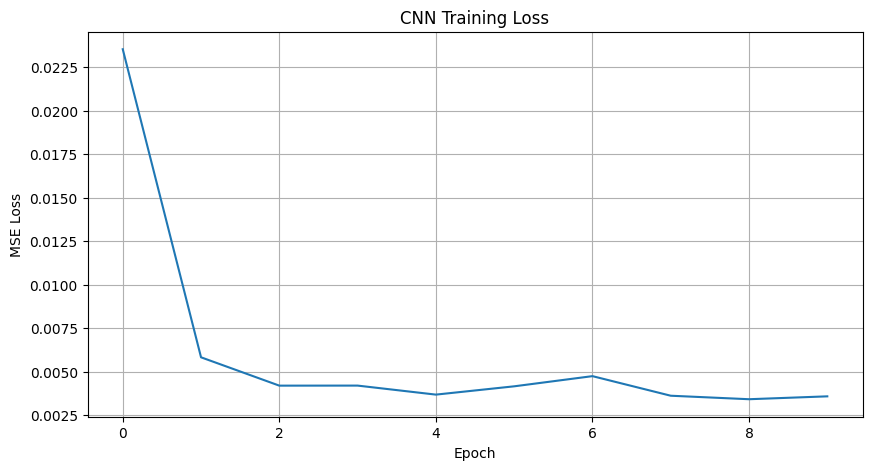

In [25]:
# Plot CNN training loss
plt.figure(figsize=(10, 5))
plt.plot(cnn_losses)
plt.title('CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

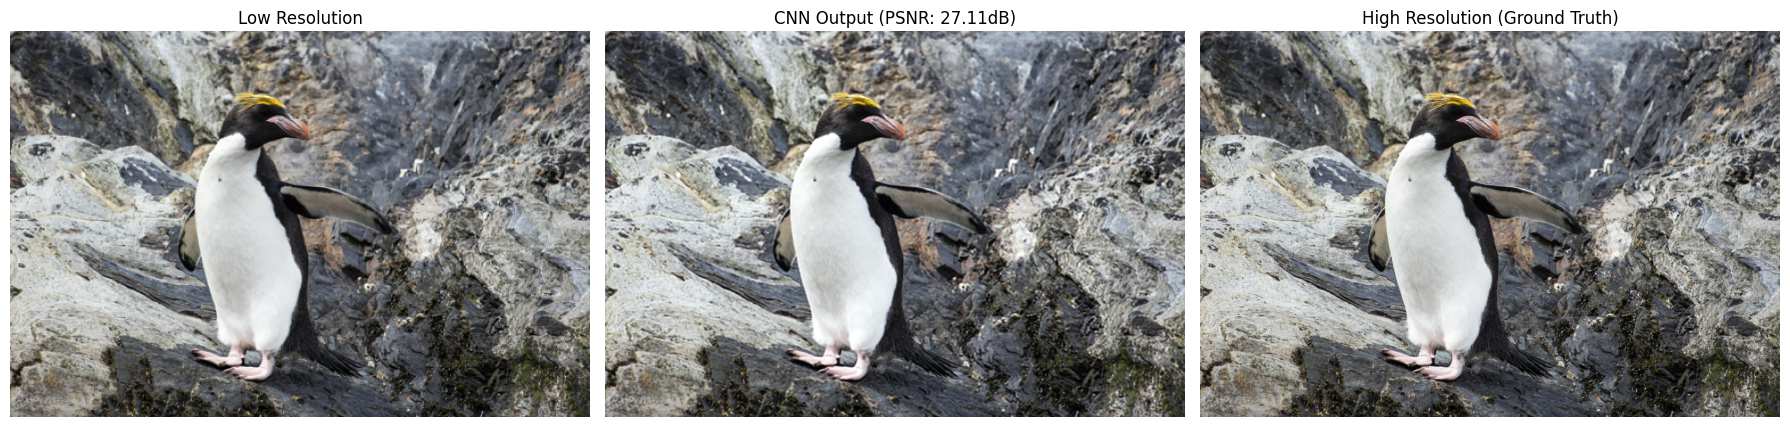

In [26]:
# Visualize CNN results
cnn_visual_psnr = visualize_results(cnn_model, test_loader, device, idx=0, title="CNN")

In [27]:
import os
if not os.path.exists("/content/drive/MyDrive"):
    from google.colab import drive
    drive.mount("/content/drive")
else:
    print("✅ Google Drive is already mounted.")


model_dir = "/content/drive/MyDrive/Final-SISR/Models"
os.makedirs(model_dir, exist_ok=True)

torch.save(cnn_model.state_dict(), os.path.join(model_dir, "sisr_cnn_10_2.pth"))
print("✅ Models saved successfully.")

Mounted at /content/drive
✅ Models saved successfully.
